In [1]:
import cv2 # for capturing videos

import math # for mathematical operations

import matplotlib.pyplot as plt # for plotting the images

import pandas as pd

from keras.preprocessing import image # for preprocessing the images

import numpy as np # for mathematical operations

from skimage.transform import resize # for resizing images

from sklearn.model_selection import train_test_split

from glob import glob

from tqdm import tqdm

2024-03-01 14:06:25.975559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 14:06:25.975660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 14:06:26.147711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import pandas as pd

# Define the paths to the folders
shoplift_folder = "/kaggle/input/shoplifting-data"
noshoplift_folder = "/kaggle/input/notshoplifting"

# Get the list of video files in each folder
shoplift_videos = [os.path.join(shoplift_folder, filename) for filename in os.listdir(shoplift_folder)]
noshoplift_videos = [os.path.join(noshoplift_folder, filename) for filename in os.listdir(noshoplift_folder)]

# Combine the lists of video files
all_videos = shoplift_videos + noshoplift_videos

# Create a DataFrame
train = pd.DataFrame({'video_name': all_videos})

print(train.head())

                                          video_name
0  /kaggle/input/shoplifting-data/shop_lifter_75.mp4
1  /kaggle/input/shoplifting-data/shop_lifter_83.mp4
2  /kaggle/input/shoplifting-data/shop_lifter_56.mp4
3  /kaggle/input/shoplifting-data/shop_lifter_48.mp4
4  /kaggle/input/shoplifting-data/shop_lifter_39.mp4


In [3]:
train_video_tag = []

for i in range(train.shape[0]):
    train_video_tag.append(train['video_name'][i].split('/')[0])

train['tag'] = train_video_tag

In [4]:
# Define paths to the folders
shoplift_folder = "/kaggle/input/shoplifting-data"
not_shoplift_folder = "/kaggle/input/notshoplifting"

# Function to store frames from videos
def store_frames_from_folder(folder_path):
    for filename in os.listdir(folder_path):
        video_file = os.path.join(folder_path, filename)
        cap = cv2.VideoCapture(video_file)
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if count % math.floor(frame_rate) == 0:
                frame_filename = f"{filename.split('.')[0]}_frame{count}.jpg"
                cv2.imwrite(frame_filename, frame)
            count += 1
        cap.release()

# Store frames from both shoplift and not shoplift folders
store_frames_from_folder(shoplift_folder)
store_frames_from_folder(not_shoplift_folder)

In [5]:
# Getting the names of all the images
images = glob("*.jpg")  # Search for all .jpg files in the current directory

train_image = []
train_class = []

for i in tqdm(range(len(images))): 
    # Creating the image name
    train_image.append(images[i])
    
    # Creating the class of image
    class_label_parts = images[i].split('_')
    class_label = class_label_parts[2]
    if class_label == 'n':
            train_class.append(0)
    else:
            train_class.append(1)

# Storing the images and their class in a DataFrame
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class 


# Converting the DataFrame into a CSV file
train_data.to_csv('train_new.csv', header=True, index=False)

100%|██████████| 3755/3755 [00:00<00:00, 568619.09it/s]


In [6]:
import keras

from keras.models import Sequential

from keras.applications.vgg16 import VGG16

from keras.layers import Dense, InputLayer, Dropout, Flatten

from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.preprocessing import image

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [7]:
train = pd.read_csv('train_new.csv')

train.head()

,image,class
0,shop_lifter_108_frame300.jpg,1
1,shop_lifter_n_2_frame75.jpg,0
2,shop_lifter_66_frame264.jpg,1
3,shop_lifter_23_frame240.jpg,1
4,shop_lifter_n_82_frame250.jpg,0


In [8]:
# creating an empty list

train_image = [] 

# for loop to read and store frames

for i in tqdm(range(train.shape[0])): 

      # loading the image and keeping the target size as (224,224,3) 

    img = image.load_img(train['image'][i], target_size=(224,224,3))

     # converting it to array

    img = image.img_to_array(img)

     # normalizing the pixel value 

    img = img/255

    # appending the image to the train_image list    

    train_image.append(img) 

# converting the list to numpy array

X = np.array(train_image) 

# shape of the array

X.shape

100%|██████████| 3755/3755 [00:13<00:00, 269.29it/s]


(3755, 224, 224, 3)

In [41]:
# separating the target

y = train['class'] 

# creating the training and validation set

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [40]:
base_model = VGG16(weights='imagenet', include_top=False)

In [43]:
# extracting features for training frames

X_train = base_model.predict(X_train)
print(X_train.shape)
# extracting features for validation frames

X_test = base_model.predict(X_test)
print(X_test.shape)

94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step
(3004, 7, 7, 512)
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 881ms/step
(751, 7, 7, 512)


In [44]:
# reshaping the training as well as validation frames in single dimension

X_train = X_train.reshape(3004, 7*7*512)
X_test = X_test.reshape(751, 7*7*512)

In [45]:
X_train = X_train/255
X_test = X_test/255

In [46]:
# shape of images

X_train.shape

(3004, 25088)

In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape

model = Sequential()

model.add(Dense(1024, activation='relu', input_shape=(25088,)))

model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))

# Define Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,388,481 (100.66 MB)

 Trainable params: 26,388,481 (100.66 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# training the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Epoch 1/10
16/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4826 - loss: 0.6935

W0000 00:00:1709305299.509402    1129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5114 - loss: 0.6945

W0000 00:00:1709305309.561781    1129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709305310.164531    1127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.5117 - loss: 0.6944 - val_accuracy: 0.9760 - val_loss: 0.5787
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8385 - loss: 0.3975 - val_accuracy: 0.9973 - val_loss: 0.0080
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9827 - loss: 0.0523 - val_accuracy: 0.9947 - val_loss: 0.0120
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9800 - loss: 0.0489 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9958 - loss: 0.0213 - val_accuracy: 1.0000 - val_loss: 6.0180e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9843 - loss: 0.0539 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9867 - loss: 0.0398 - val_accuracy: 1.0000 - val_loss: 2.4949e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9874 - loss: 0.0315 - val_accuracy: 1.0000 - va

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

W0000 00:00:1709305325.918712    1128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


Text(0.5, 25.722222222222214, 'Actual')

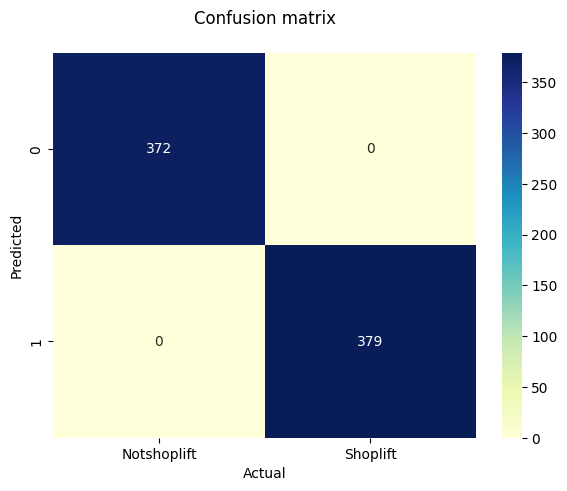

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = model.predict(X_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=[0, 1], columns=['Notshoplift', 'Shoplift'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

In [71]:
model.save('mod1.h5')

In [69]:
from keras.models import load_model
folder = '/kaggle/input/tryshopliftt'

predict = []

# Function to store frames from videos
def store_frames_folder(folder_path):
    model=load_model('mod1.h5')
    for filename in os.listdir(folder_path):
        video_file = os.path.join(folder_path, filename)
        cap = cv2.VideoCapture(video_file)
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        
        # Extract features using pre-trained model
        prediction_images = []
        for img in frames:
            img = cv2.resize(img, (224, 224))
            img = image.img_to_array(img)
            img = img / 255
            prediction_images.append(img)

        # Convert all the frames for a test video into numpy array
        prediction_images = np.array(prediction_images)
        
        # Extract features using pre-trained model
        prediction_images = base_model.predict(prediction_images)
        
        # Convert features into one-dimensional array
        prediction_images = prediction_images.reshape(prediction_images.shape[0], 7 * 7 * 512)
        
        # Predict tags for each array
        predictions = model.predict(prediction_images)
        
        # Append the mode of predictions in predict list to assign the tag to the video
        # Assuming 0 corresponds to "not shoplift" and 1 corresponds to "shoplift"
        # Use majority voting to determine the predicted class label
        predicted_class = "shoplift" if np.mean(predictions) > 0.5 else "not shoplift"
        predict.append(predicted_class)

    return predict
    
predictions = store_frames_folder(folder)
print(predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


W0000 00:00:1709307750.311527    1129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709307750.499080    1127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


['shoplift']
